# Assignment 3 - Quora Insincere Questions Classification (Kaggle)

## Preprocessing

### Get Data

In [1]:
# Add imports
import numpy as np # linear algebra
import torch as pt
from torch import nn, Tensor

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

# Make sure data is correct
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


In [2]:
# Set usable data locations
TRAIN_DATA_LOCATION = "/kaggle/input/quora-insincere-questions-classification/train.csv"
VALID_DATA_LOCATION = "/kaggle/input/quora-insincere-questions-classification/test.csv"
EMBEDDINGS_LOCATION = "/kaggle/input/quora-insincere-questions-classification/embeddings.zip"

In [3]:
# Set working device
DEVICE = pt.device("cuda" if pt.cuda.is_available() else "cpu")

DEVICE

device(type='cuda')

In [4]:
labeled_data = pd.read_csv(TRAIN_DATA_LOCATION)
test_data = pd.read_csv(VALID_DATA_LOCATION)

In [5]:
# Divide labeled data into train and valid

# Randomly shuffle data
labeled_data = labeled_data.sample(frac=1).reset_index(drop=True)

# Split data into 60/40 parts
partition_index = int(labeled_data.shape[0] * 0.8)

train_data = labeled_data.iloc[:partition_index, :]
valid_data = labeled_data.iloc[partition_index: , :]

train_data.shape, valid_data.shape

((1044897, 3), (261225, 3))

### EDA

In [6]:
train_data.head()

,qid,question_text,target
0,cdc4a6fa4551be0c86f9,Why are Democrats still having a hard time acc...,1
1,c1e8b299b0087ea20d5e,What should be done after B.Sc (Honors) Comput...,0
2,7fcd759ff9e52cfc6d61,What's the raddest punchline?,0
3,82c5fc006d9e0181cd50,What do I do if I am deeply troubled by the fa...,1
4,d5961a78e6a5ffbb028d,What's a good way to be funny?,0


In [7]:
# Remove unnecessary qid collumn
del train_data['qid']
del valid_data['qid']

# Save test qid's for final submission.csv
test_qids = test_data['qid']
del test_data['qid']

In [8]:
train_data.head()

,question_text,target
0,Why are Democrats still having a hard time acc...,1
1,What should be done after B.Sc (Honors) Comput...,0
2,What's the raddest punchline?,0
3,What do I do if I am deeply troubled by the fa...,1
4,What's a good way to be funny?,0


In [9]:
# Change data to numpy to work with pytorch

train_data = train_data.to_numpy()
valid_data = valid_data.to_numpy()
test_data = test_data.to_numpy()

In [10]:
# Split insincere questions from sincere for analysis
sincere_data = []
insincere_data = []
for text, label in train_data:
    if label == 1: insincere_data.append(text)
    else: sincere_data.append(text)

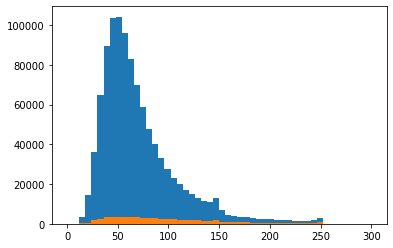

In [11]:
# Plot histogram of question lenghts, and insencere data distribution in different length datas

sinc_seq_lens = [len(text) for text, _ in train_data]
insinc_seq_lens = [len(text) for text in insincere_data]

plt.hist(sinc_seq_lens, bins=50, range=(0, 300))
plt.hist(insinc_seq_lens, bins=50, range=(0, 300));

In [12]:
# Most of the text is at most 100 words long, so let's set maximum sequence lenght to 100
MAX_SEQ_LEN = 100

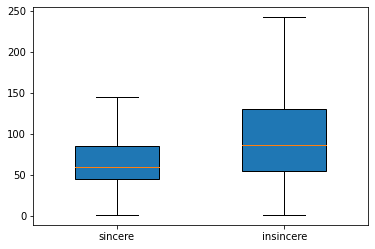

In [13]:
# Boxplot for targer vs total words
# we can clearly see that insincere questions tend to be longer.
plt.boxplot(
    [sinc_seq_lens, insinc_seq_lens], 
    labels=["sincere", "insincere"], 
    widths=0.5, 
    patch_artist=True, 
    autorange=True, 
    showfliers=False
);

Sincere data makes 93.82101776538741 of train data
Insincere data makes 6.17898223461259 of train data


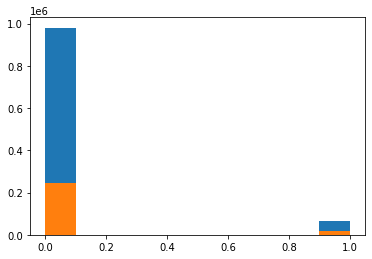

In [14]:
# Classes are not evenly distributed. Insincere questions are far less common.
# This could lead to model underfiting the data and only returning sincere as an anwser
#
# Train/Validation data label distributions match often, dispite random distribution.

y_train = [label for _, label in train_data]
y_valid = [label for _, label in valid_data]

sincere_percentage = (len(sincere_data) / (len(sincere_data) + len(insincere_data))) * 100
print(f"Sincere data makes {sincere_percentage} of train data")
print(f"Insincere data makes {100 - sincere_percentage} of train data")

plt.hist(y_train)
plt.hist(y_valid);

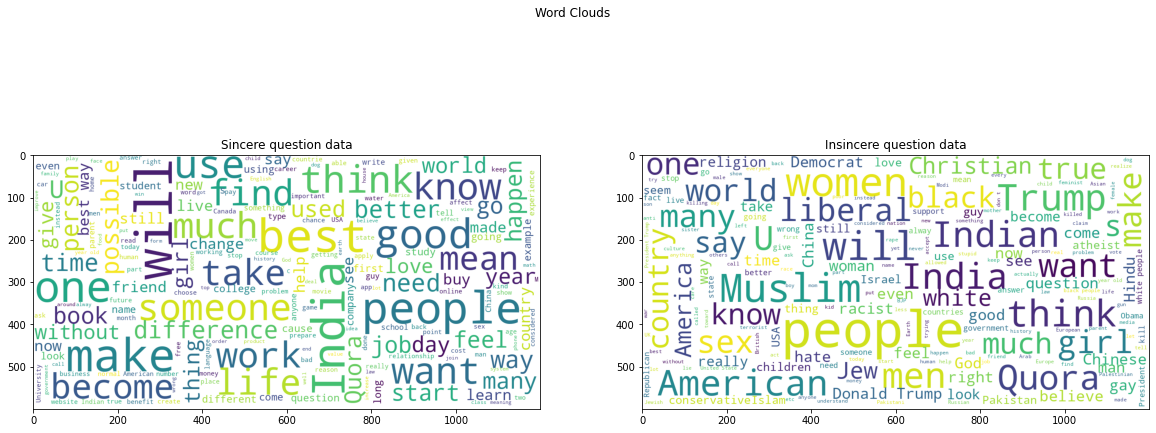

In [15]:
# drow word clouds to see most and least common words
#
# We can see that insincere questions contain a lot of political, race or religion related
# words, like: Liberal, Trump, Indian, Black, White, Muslim, Christian...

from wordcloud import WordCloud

fig, axes = plt.subplots(1, 2, figsize=(20,8))
fig.suptitle('Word Clouds')

word_cloud = WordCloud(background_color='white', max_words=200, max_font_size=40, scale=3)

sinceres_string = " ".join(sincere_data)
insinceres_string = " ".join(insincere_data)

axes[0].set_title("Sincere question data")
axes[0].imshow(word_cloud.generate(sinceres_string))

axes[1].set_title("Insincere question data")
axes[1].imshow(word_cloud.generate(insinceres_string));

In [16]:
# Install torchtext, torchdata, to build vocabularies
!pip install torchtext

In [17]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

vocab = build_vocab_from_iterator(
    map(tokenizer, train_data[:, 0]),     
    min_freq=3, 
    specials=['<unk>', '<bos>', '<eos>'],
)
vocab.set_default_index(vocab['<unk>'])

In [18]:
len(vocab) - 3 # Vocabulary length minus special tokens

65683

In [19]:
vocab.get_itos()[:10]

['<unk>', '<bos>', '<eos>', '?', 'the', 'what', 'is', 'a', 'to', 'in']

In [20]:
# Shorten incomming text to MAX_SEQ_SIZE
def truncate_text(tokenized_text):
    return tokenized_text[:min(MAX_SEQ_LEN, len(tokenized_text))]

text_pipeline = lambda x: vocab(truncate_text(tokenizer(x)))

In [21]:
# Batchify train and valid data
from torch.utils.data import DataLoader

BATCH_SIZE = 128

def collate_batch(batch):
    label_list = []
    text_list = []
    
    for text, label in batch:
        label_list.append(label)
        text_indices = pt.zeros(MAX_SEQ_LEN, dtype=pt.int32)
        processed_text = text_pipeline(text)
        text_indices[:len(processed_text)] = pt.tensor(processed_text, dtype=pt.long)
        text_list.append(text_indices)
        
    label_list = pt.tensor(label_list, dtype=pt.int32)
    text_list = pt.stack(text_list, dim=0)
    
    return text_list, label_list

train_labels = [label for _, label in train_data]
train_data = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_data = DataLoader(valid_data, batch_size=BATCH_SIZE * 2, shuffle=False, collate_fn=collate_batch)

In [22]:
print(train_labels[0])
for x, y in train_data:
    print(x.shape, y.shape)
    break

1
torch.Size([128, 100]) torch.Size([128])


In [23]:
# Batchify test data to save memory during prediction
def collate_batch_test_data(batch):    
    text_list = []

    for text in batch:
        text_indices = pt.zeros(MAX_SEQ_LEN, dtype=pt.int32)
        processed_text = text_pipeline(text[0]) # text return a 1 element array, [0] gets that element
        text_indices[:len(processed_text)] = pt.tensor(processed_text, dtype=pt.long)
        text_list.append(text_indices)

    test_data = pt.stack(text_list, dim=0)
    return test_data
    
test_data = DataLoader(test_data, batch_size=BATCH_SIZE * 4, shuffle=False, collate_fn=collate_batch_test_data)

## Defining Neural Network Model and Training

### Get Word Embeddings

In [24]:
# unzip embeddings.zip to download embeddings
!unzip /kaggle/input/quora-insincere-questions-classification/embeddings.zip

Archive:  /kaggle/input/quora-insincere-questions-classification/embeddings.zip
   creating: GoogleNews-vectors-negative300/
   creating: glove.840B.300d/
   creating: paragram_300_sl999/
   creating: wiki-news-300d-1M/
  inflating: glove.840B.300d/glove.840B.300d.txt  
  inflating: GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin  
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  
  inflating: paragram_300_sl999/README.txt  
  inflating: paragram_300_sl999/paragram_300_sl999.txt  


In [25]:
# Download glove vectors
from torchtext.vocab import Vectors

GLOVE_PATH = "glove.840B.300d/glove.840B.300d.txt"
glove = Vectors(GLOVE_PATH, cache='glove', url=None)

100%|█████████▉| 2196016/2196017 [04:09<00:00, 8809.88it/s]


In [26]:
# Get glove vectors for vocabulary words
vecs = glove.get_vecs_by_tokens(vocab.get_itos())
vecs.shape

torch.Size([65686, 300])

### Define Neural Netword Model

In [27]:
# Build classifier model with neural networks
class Classifier(nn.Module):
    def __init__(self, hidden_layer_sizes = []):
        super().__init__()
        
        # Define acivation functions
        self.midAct = nn.functional.relu
        self.finAct = nn.functional.softmax
        
        # Define embedding layer
        self.emb = nn.Embedding(
            num_embeddings=len(vocab),                     
            embedding_dim=vecs.shape[1],
            padding_idx=0,
            sparse=False
        )
        
        self.emb.weight = nn.Parameter(vecs)
        self.emb.weight.requires_grad = False
        
        # Make a neural network with len(hidden_layer_size) hidden layers
        prev_size = vecs.shape[1]
        self.hidden_layers = []
        for hidden_size in hidden_layer_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size, bias=True))
            prev_size = hidden_size
            
        # Finish neural network with final classifier layer
        self.classifier_layer = nn.Linear(prev_size, 2, bias=False)
        
    def forward(self, x):
        embedding = self.emb(x).sum(dim=1)
        
        return_value = embedding
        for layer in self.hidden_layers:
            layer.to(DEVICE)
            return_value = self.midAct(layer(return_value))
            
        return_value = self.finAct(self.classifier_layer(return_value), dim=1)
        return return_value

### Train Model

In [28]:
# Validation data metrics
def calc_accuracy(model: nn.Module):
    model.eval()

    Y, Y_PRED, Y_VAL = [], [], []
    with pt.no_grad():
        for i, (x, y) in enumerate(valid_data):
            y_pred = model(x.to(DEVICE))

            Y.extend(y.tolist())
            Y_PRED.extend(y_pred.argmax(dim=1).tolist())
            Y_VAL.append(y_pred.cpu())

    loss = pt.nn.functional.cross_entropy(pt.cat(Y_VAL, dim=0), pt.LongTensor(Y)).item()

    return loss, Y, Y_PRED

In [29]:
# Train Model
from sklearn.utils import class_weight

def train(model, train_data, valid_data, num_epochs):
    model = model.to(DEVICE)
    
    # use ADAM optimizer with L2 regularization (weigth_decay, to avoid overfitting)
    optimizer = pt.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    
    # class weights are needed to balance out the bad distribution of classes.
    class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=train_labels)
    class_weights = pt.tensor(class_weights, dtype=pt.float).to(DEVICE)
    crit = nn.CrossEntropyLoss(reduction='mean', weight=class_weights)
    
    train_loss_array = []
    valid_loss_array = []
    
    train_loss_average = 0
    valid_loss_average = 0
    
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(train_data):
            optimizer.zero_grad()
            
            y_pred = model(x.to(DEVICE))
            loss = crit(y_pred, y.to(DEVICE).long())
            loss.backward()
            optimizer.step()
            
        print('Epoch', epoch + 1, 'Loss', loss.item())
        
        train_loss_average += loss.item()
        valid_loss_average += calc_accuracy(model)[0]
    
        # Plot the average loss, SGD loss doesn't necessarily decreas on every epoch
        if (epoch + 1) % 3 == 0:
            train_loss_array.append(train_loss_average / 5)
            valid_loss_array.append(valid_loss_average / 5)
            
            train_loss_average = 0
            valid_loss_average = 0
        
    return model, train_loss_array, valid_loss_array

In [30]:
# Build and train a model
model = Classifier([258, 258]).to(DEVICE)
EPOCHS = 50
model, train_loss_array, valid_loss_array = train(model, train_data, valid_data, EPOCHS)

Epoch 1 Loss 0.4647504389286041
Epoch 2 Loss 0.4509907364845276
Epoch 3 Loss 0.4333586096763611
Epoch 4 Loss 0.46950745582580566
Epoch 5 Loss 0.43848708271980286
Epoch 6 Loss 0.4207001328468323
Epoch 7 Loss 0.37321799993515015
Epoch 8 Loss 0.5311107039451599
Epoch 9 Loss 0.5934199094772339
Epoch 10 Loss 0.36296772956848145
Epoch 11 Loss 0.4348255395889282
Epoch 12 Loss 0.7164309620857239
Epoch 13 Loss 0.5985759496688843
Epoch 14 Loss 0.3748106062412262
Epoch 15 Loss 0.4344148635864258
Epoch 16 Loss 0.4009176790714264
Epoch 17 Loss 0.4856971502304077
Epoch 18 Loss 0.4308444857597351
Epoch 19 Loss 0.43020570278167725
Epoch 20 Loss 0.41737258434295654
Epoch 21 Loss 0.4680526554584503
Epoch 22 Loss 0.5077052116394043
Epoch 23 Loss 0.46994149684906006
Epoch 24 Loss 0.40414756536483765
Epoch 25 Loss 0.40711772441864014
Epoch 26 Loss 0.5013179779052734
Epoch 27 Loss 0.6931368708610535
Epoch 28 Loss 0.4209475517272949
Epoch 29 Loss 0.4920622706413269
Epoch 30 Loss 0.4218636751174927
Epoch 31 L

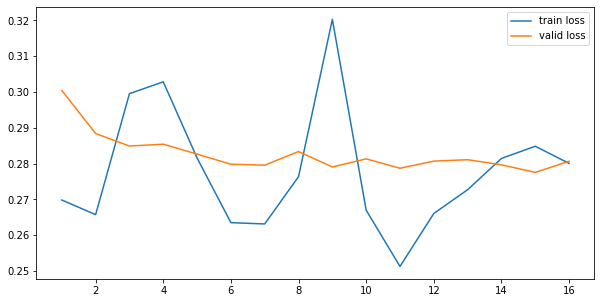

In [31]:
# Even though train data is a bit jumpy, validation data loss steadily decreases
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss_array) + 1), train_loss_array, label="train loss")
plt.plot(range(1, len(valid_loss_array) + 1), valid_loss_array, label="valid loss")
plt.legend(loc=1);

In [32]:
# Define confusion matrix function
import itertools
from sklearn.metrics import confusion_matrix

def draw_confusion_matrix(y, y_pred, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    cm = confusion_matrix(y, y_pred)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show

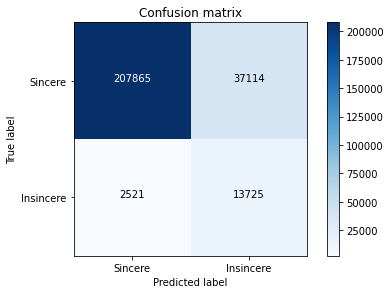

In [33]:
_, Y, Y_PRED = calc_accuracy(model)
draw_confusion_matrix(Y, Y_PRED, ['Sincere', 'Insincere'])

In [34]:
# Get validation F1 score
from sklearn.metrics import f1_score

print("F1 Score: ", f1_score(Y, Y_PRED))

F1 Score:  0.40918238056197365


### Export Data

In [35]:
# Predict the test_data results and save in a csv file for final output.
test_pred = []
for x in test_data:
    y_pred = model(x.to(DEVICE))
    test_pred.extend(y_pred.argmax(dim=1).tolist())
    
submission = pd.DataFrame.from_dict({'qid': test_qids})
submission['prediction'] = pd.DataFrame(test_pred)
submission.to_csv('submission.csv', index=False)